# TODO
- Time forecasts
- Work this prototype notebook into scripts for pipeline when ready
- More plots and EDA
- output forecast for visualization

In [38]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
import numpy as np
import gcsfs
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

## Load Data

In [39]:
# making sure this works - it does
#fs = gcsfs.GCSFileSystem(project='cse6242-project-476314', token = 'google_default')
#with fs.open('cse6242-project-data-bucket/Zip_zori_uc_sfrcondomfr_sm_sa_month.csv') as f:
#    zori_wide = pd.read_csv(f)
zori_wide = pd.read_csv('Zip_zori_uc_sfrcondomfr_sm_sa_month.csv')
zori_wide

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2015-01-31,...,2024-12-31,2025-01-31,2025-02-28,2025-03-31,2025-04-30,2025-05-31,2025-06-30,2025-07-31,2025-08-31,2025-09-30
0,91982,1,77494,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,1501.705581,...,1902.035623,1902.589323,1894.295923,1891.247836,1889.899732,1889.783368,1886.582030,1887.378619,1888.256767,1891.123162
1,91940,3,77449,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,1252.988450,...,1834.055010,1834.801216,1836.145502,1835.505043,1831.819858,1833.617479,1829.740778,1831.288573,1825.781679,1829.945544
2,91733,5,77084,zip,TX,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,1127.656461,...,1625.302516,1624.803898,1632.635241,1632.612081,1630.639582,1615.873819,1614.456853,1619.566427,1630.300973,1634.061782
3,93144,6,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,NaN,...,1426.444928,1435.425031,1443.855231,1446.723283,1441.421688,1439.302928,1441.642569,1448.088589,1456.518933,1463.357895
4,62093,7,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,NaN,...,3150.113998,3186.884070,3216.427094,3224.476398,3223.466612,3234.890106,3255.649669,3275.779831,3277.512495,3300.138507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7848,418163,30158,89158,zip,NV,NV,Las Vegas,"Las Vegas-Henderson-Paradise, NV",Clark County,NaN,...,NaN,NaN,NaN,NaN,NaN,3066.735205,3141.404502,3220.651060,NaN,3383.333333
7849,70410,30172,29333,zip,SC,SC,Spartanburg,"Spartanburg, SC",Spartanburg County,NaN,...,NaN,NaN,NaN,NaN,1496.722526,1492.599968,1467.567991,1471.938011,1447.380379,1441.444444
7850,61618,30490,10004,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",New York County,NaN,...,4953.861191,4992.794726,5020.881625,4966.573186,4993.118270,4985.137479,5019.837773,5064.354786,5128.502857,5207.319444
7851,91179,30490,76005,zip,TX,TX,Arlington,"Dallas-Fort Worth-Arlington, TX",Tarrant County,NaN,...,2266.033986,2269.037047,2240.741193,2237.569443,2215.046263,2215.363392,2210.884130,2224.301864,2214.883471,2216.444444


In [40]:
# get into long format
value_vars = [col for col in zori_wide.columns if col[:4].isdigit()]

zori = zori_wide.melt(
    id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName'],
    value_vars = value_vars,
    var_name='Date',
    value_name='Rent'
)

# format date
zori['Date'] = pd.to_datetime(zori['Date'])

# rename RegionID to ZIP
zori = zori.rename(columns={'RegionID':'ZIP'})

# sort time series
zori = zori.sort_values(['ZIP', 'Date'])

zori

,ZIP,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Date,Rent
3692,58197,3911,1002,zip,MA,MA,Amherst,"Springfield, MA",Hampshire County,2015-01-31,NaN
11545,58197,3911,1002,zip,MA,MA,Amherst,"Springfield, MA",Hampshire County,2015-02-28,NaN
19398,58197,3911,1002,zip,MA,MA,Amherst,"Springfield, MA",Hampshire County,2015-03-31,NaN
27251,58197,3911,1002,zip,MA,MA,Amherst,"Springfield, MA",Hampshire County,2015-04-30,NaN
35104,58197,3911,1002,zip,MA,MA,Amherst,"Springfield, MA",Hampshire County,2015-05-31,NaN
...,...,...,...,...,...,...,...,...,...,...,...
979408,845914,6361,85288,zip,AZ,AZ,Tempe,"Phoenix-Mesa-Chandler, AZ",Maricopa County,2025-05-31,2000.823720
987261,845914,6361,85288,zip,AZ,AZ,Tempe,"Phoenix-Mesa-Chandler, AZ",Maricopa County,2025-06-30,2003.705718
995114,845914,6361,85288,zip,AZ,AZ,Tempe,"Phoenix-Mesa-Chandler, AZ",Maricopa County,2025-07-31,2020.338279
1002967,845914,6361,85288,zip,AZ,AZ,Tempe,"Phoenix-Mesa-Chandler, AZ",Maricopa County,2025-08-31,2046.337532


## Data Inspection

In [41]:
zori.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1013037 entries, 3692 to 1010820
Data columns (total 11 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   ZIP         1013037 non-null  int64         
 1   SizeRank    1013037 non-null  int64         
 2   RegionName  1013037 non-null  int64         
 3   RegionType  1013037 non-null  object        
 4   StateName   1013037 non-null  object        
 5   State       1013037 non-null  object        
 6   City        1005555 non-null  object        
 7   Metro       1008006 non-null  object        
 8   CountyName  1013037 non-null  object        
 9   Date        1013037 non-null  datetime64[ns]
 10  Rent        396233 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 92.7+ MB


In [42]:
zori.describe()

,ZIP,SizeRank,RegionName,Date,Rent
count,1.013037e+06,1.013037e+06,1.013037e+06,1013037,396233.000000
mean,8.469800e+04,4.770870e+03,5.263820e+04,2020-05-30 20:39:04.186046720,1814.321472
min,5.819700e+04,1.000000e+00,1.002000e+03,2015-01-31 00:00:00,528.828904
25%,7.036500e+04,2.037000e+03,2.915000e+04,2017-09-30 00:00:00,1301.376023
50%,7.948800e+04,4.178000e+03,4.842300e+04,2020-05-31 00:00:00,1649.037387
75%,9.326100e+04,6.735000e+03,7.993200e+04,2023-01-31 00:00:00,2128.800125
max,8.459140e+05,3.049000e+04,9.980100e+04,2025-09-30 00:00:00,99629.555556
std,4.216436e+04,3.566825e+03,2.993071e+04,NaN,1108.741032


In [43]:
# missing values
zori.isna().sum()

ZIP                0
SizeRank           0
RegionName         0
RegionType         0
StateName          0
State              0
City            7482
Metro           5031
CountyName         0
Date               0
Rent          616804
dtype: int64

In [44]:
# spacing
zori['gap_days']  = zori.groupby('ZIP')['Date'].diff().dt.days
anomalies = zori[zori['gap_days'] > 31]
anomalies.head()

,ZIP,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Date,Rent,gap_days


In [45]:
# Handle missingness for Rent - forecasts will either skip over missing data (ETS) or distort mean (averages/std for volatility)
# TODO: really handle it this way?
zori['Rent'] = (
    zori.groupby('ZIP')['Rent']
        .transform(lambda s: s.interpolate(method='linear', limit_direction='both'))
)
# formatting Date to prevent future warning
zori['Date'] = zori['Date'].dt.to_period('M').dt.to_timestamp('M')

# initial volatility measurement
zori['pct_change'] = (zori.groupby('ZIP')['Rent'].transform(lambda s: s.pct_change()))

zori['volatility'] = (zori.groupby('ZIP')['pct_change'].transform(lambda s: s.rolling(12, min_periods=6).std()))

zori.isna().sum()

ZIP               0
SizeRank          0
RegionName        0
RegionType        0
StateName         0
State             0
City           7482
Metro          5031
CountyName        0
Date              0
Rent              0
gap_days       7853
pct_change     7853
volatility    47118
dtype: int64

In [46]:
zori['gap_days']  = zori.groupby('ZIP')['Date'].diff().dt.days
anomalies = zori[zori['gap_days'] > 31]
anomalies.head()

,ZIP,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Date,Rent,gap_days,pct_change,volatility


In [47]:
# TODO - temporary filter for testing
zori_test = zori[(zori['State'] == 'GA') | (zori['State'] == 'TX')]
zori_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 123324 entries, 268 to 1008380
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   ZIP         123324 non-null  int64         
 1   SizeRank    123324 non-null  int64         
 2   RegionName  123324 non-null  int64         
 3   RegionType  123324 non-null  object        
 4   StateName   123324 non-null  object        
 5   State       123324 non-null  object        
 6   City        121389 non-null  object        
 7   Metro       122808 non-null  object        
 8   CountyName  123324 non-null  object        
 9   Date        123324 non-null  datetime64[ns]
 10  Rent        123324 non-null  float64       
 11  gap_days    122368 non-null  float64       
 12  pct_change  122368 non-null  float64       
 13  volatility  117588 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(3), object(6)
memory usage: 14.1+ MB


## Evaluation

In [48]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [49]:
def rolling_cv(series, horizon=3, min_train=24, step=3, max_folds=12, seasonal=False):
    ''' 
    Return the average RMSEs for ETS and Linear models.
    '''
    series = series.dropna().astype(float)
    n = len(series)
    if n < min_train + horizon:
        return np.nan, np.nan

    # choosing a limited set of origin points to reduce computation time
    origins = list(range(min_train, n - horizon + 1, step))
    if len(origins) > max_folds:
        # keep the last max_folds origins for recent data emphasis
        origins = origins[-max_folds:]

    rmse_ets, rmse_lin = [], []
    mae_ets, mae_lin = [], []

    for i in origins:
        train = series.iloc[:i]
        test = series.iloc[i:i+horizon]

        # ETS
        try:
            ets = ExponentialSmoothing(train, trend='add', seasonal=None if not seasonal else 'add', seasonal_periods=12 if seasonal else None).fit(optimized=True)
            pred_ets = ets.forecast(horizon)
            rmse_ets.append(rmse(test, pred_ets))
            mae_ets.append(mean_absolute_error(test, pred_ets))
        except Exception:
            pass

        # Linear
        X = np.arange(len(train)).reshape(-1, 1)
        lr = LinearRegression().fit(X, train.values)
        X_future = np.arange(len(train), len(train)+horizon).reshape(-1, 1)
        pred_lr = lr.predict(X_future)
        rmse_lin.append(rmse(test, pred_lr))
        mae_lin.append(mean_absolute_error(test, pred_lr))

    return np.mean(rmse_ets), np.mean(rmse_lin), np.mean(mae_ets), np.mean(mae_lin)

In [50]:
%%time
zori = zori_test.copy() #TODO: temporary
results = []

for zip_code, g in zori.groupby('ZIP'):
    series = (
        g.sort_values('Date')
         .assign(Date=lambda d: pd.to_datetime(d['Date']).dt.to_period('M').dt.to_timestamp('M'))
         .set_index('Date')['Rent']
         .asfreq('ME')
    )
    ets_rmse, lin_rmse, ets_mae, lin_mae = rolling_cv(series, horizon=3)
    results.append({'ZIP': zip_code,
                    'RMSE_ExpSmooth': ets_rmse,
                    'RMSE_Linear': lin_rmse,
                    'MAE_ExpSmooth': ets_mae,
                    'MAE_Linear':lin_mae})

cv_df = pd.DataFrame(results)

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:1412: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:1419: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:1412: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:1419: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:1412: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/opt/anaconda3/lib/pyth

CPU times: user 1min 25s, sys: 684 ms, total: 1min 25s
Wall time: 1min 26s


In [51]:
# summarize results
cv_df.describe()

,ZIP,RMSE_ExpSmooth,RMSE_Linear,MAE_ExpSmooth,MAE_Linear
count,956.000000,956.000000,956.000000,956.000000,956.000000
mean,90254.235356,16.865592,52.839401,15.133313,51.984083
std,42802.125585,10.449775,38.432178,9.461920,38.358578
min,70791.000000,0.000000,0.000000,0.000000,0.000000
25%,71715.750000,10.500261,23.622309,9.448153,22.761539
50%,91328.500000,16.090712,51.501315,14.344753,50.578276
75%,92132.000000,22.016915,73.152628,19.806412,72.312573
max,787971.000000,112.439679,362.961862,100.013241,359.398344


In [52]:
# How many ZIPs each model wins
(cv_df['RMSE_ExpSmooth'] < cv_df['RMSE_Linear']).mean()

np.float64(0.8828451882845189)

In [53]:
(cv_df['MAE_ExpSmooth'] < cv_df['MAE_Linear']).mean()

np.float64(0.8870292887029289)

Text(0.5, 1.0, 'Distribution of 3-Month RMSE by Model')

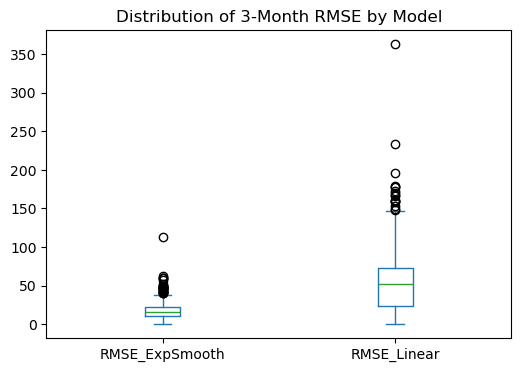

In [54]:
cv_df[['RMSE_ExpSmooth','RMSE_Linear']].plot(kind='box', figsize=(6,4))
plt.title('Distribution of 3-Month RMSE by Model')

Text(0.5, 1.0, 'Distribution of 3-Month MAE by Model')

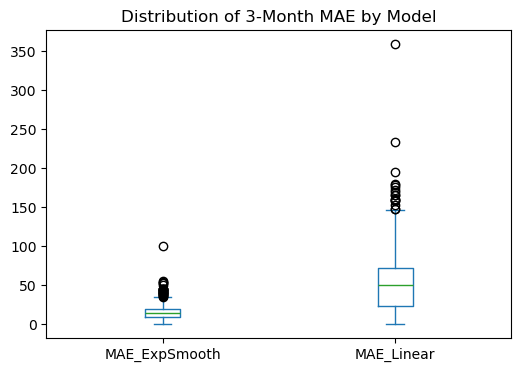

In [55]:
cv_df[['MAE_ExpSmooth','MAE_Linear']].plot(kind='box', figsize=(6,4))
plt.title('Distribution of 3-Month MAE by Model')

## Forecast

In [56]:
def forecast_zip(group):
    '''
    Input is group pertaining to a ZIP
    '''
    group = group.sort_values('Date').copy()

    train = group.set_index('Date')['Rent'].asfreq('ME')
    # skip short series
    #if len(train) < 24:
    #    return pd.DataFrame()  

    # Exponential Smoothing
    model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)
    #model = ExponentialSmoothing(train, trend='add', seasonal=None)
    fit = model.fit()
    forecast = fit.forecast(12)

    # Linear Baseline
    #y = train.values
    #t = np.arange(len(train)).reshape(-1,1)
    #lr = LinearRegression().fit(t, y)
    #future_t = np.arange(len(train), len(train)+12).reshape(-1, 1)
    #forecast_lr = lr.predict(future_t)

    # Combine the forecasts into a dataframe
    future_dates = pd.date_range(group['Date'].max() + pd.offsets.MonthBegin(), periods=12, freq='ME')

    df_fore = pd.DataFrame({
        'ZipCode': group['ZIP'].iloc[0],
        'Date': future_dates,
        'Forecast_Rent': forecast.values,
    })

    # add volatility 
    df_fore['pct_change'] = df_fore['Forecast_Rent'].pct_change() 
    df_fore['volatility'] = (df_fore['pct_change'].rolling(12, min_periods=3).std()) 
    
    # smooth start so line looks continuous 
    last_hist_vol = group['volatility'].iloc[-1] if 'volatility' in group else np.nan 
    df_fore['volatility'] = df_fore['volatility'] = df_fore['volatility'].ffill().fillna(last_hist_vol)

    return df_fore

In [57]:
# apply the ets forecast to all zipcodes
all_forecasts = (
    zori.groupby('ZIP', group_keys=False)
    .apply(forecast_zip)
    .reset_index(drop=True)
)

/var/folders/v6/rt7shrqx5sldb75bkwymnhlw0000gp/T/ipykernel_78088/2366631492.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(forecast_zip)


In [58]:
# extract our target forecasts - 3, 6, 9, 12 month
horizons = [3, 6, 9, 12]
summary = []

for zip_code, df in all_forecasts.groupby('ZipCode'):
    for h in horizons:
        if len(df) >= h:
            summary.append({
                'ZipCode': zip_code,
                'Forecast_Month': h,
                'Forecast_Rent': df['Forecast_Rent'].iloc[h-1],
                'Volatility': df['volatility'].iloc[h-1],
            })

zip_forecast_summary = pd.DataFrame(summary)

zip_forecast_summary

,ZipCode,Forecast_Month,Forecast_Rent,Volatility
0,70791,3,2116.990125,0.003317
1,70791,6,2138.247897,0.000831
2,70791,9,2166.455407,0.000751
3,70791,12,2195.540812,0.000772
4,70792,3,2119.848856,0.005763
...,...,...,...,...
3819,787970,12,2575.069319,0.000409
3820,787971,3,2768.750580,0.011933
3821,787971,6,2791.892100,0.000849
3822,787971,9,2810.128507,0.000997


In [59]:
zip_forecast_summary.describe()

,ZipCode,Forecast_Month,Forecast_Rent,Volatility
count,3824.000000,3824.000000,3824.000000,3824.000000
mean,90254.235356,7.500000,1703.386656,0.002268
std,42785.328361,3.354541,402.321160,0.003346
min,70791.000000,3.000000,645.912320,0.000000
25%,71715.750000,5.250000,1430.771588,0.000521
50%,91328.500000,7.500000,1683.895331,0.000786
75%,92132.000000,9.750000,1933.539041,0.002388
max,787971.000000,12.000000,4058.696674,0.034335


In [22]:
# TODO: save somewhere our where does it go? send to gcp?
#zip_forecast_summary.to_csv('ZIP_forecasts.csv', index=False)